In [1]:
import chainer as ch
import numpy as np

ch.config.debug = True

In [2]:
print(ch.print_runtime_info())

Platform: Linux-5.4.0-81-generic-x86_64-with-Ubuntu-18.04-bionic
Chainer: 7.8.0
ChainerX: Not Available
NumPy: 1.19.5
CuPy:
  CuPy Version          : 7.8.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 11010
  CUDA Runtime Version  : 10010
  cuBLAS Version        : 10201
  cuFFT Version         : 10101
  cuRAND Version        : 10101
  cuSOLVER Version      : (10, 2, 0)
  cuSPARSE Version      : 10300
  NVRTC Version         : (10, 1)
  cuDNN Build Version   : 7605
  cuDNN Version         : 7605
  NCCL Build Version    : 2708
  NCCL Runtime Version  : 2708
  CUB Version           : None
  cuTENSOR Version      : None
iDeep: Not Available
None


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Shape of train (50000, 2)
Shape of x (784,)
Some raw x [0.8862746  0.83921576 0.8745099  0.97647065 0.7176471  0.75294125
 0.9725491  0.23529413 0.2509804  0.54509807 0.4901961  0.45098042
 0.16078432 0.2509804  0.53333336 0.94117653 0.7019608  0.61960787
 0.9294118  0.8980393 ]


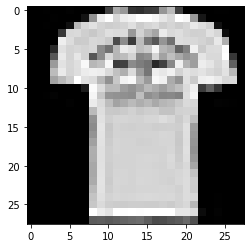

label: T-shirt/top


In [3]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']

train, test = get_fashion_mnist(withlabel=True, ndim=1)
train, valid = ch.datasets.split_dataset_random(train, 50000, seed=0)

%matplotlib inline
import matplotlib.pyplot as plt

x, t = train[0]

print('Shape of train', np.shape(train))
print('Shape of x', x.shape)
print('Some raw x', x[200:220])

plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', labels[t])

In [4]:
train

In [5]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [6]:
import chainer.functions as F
import chainer.links as L

In [7]:
# multilayer perceptron
def MLP():
    layer = ch.Sequential(L.Linear(100), F.relu)
    model = layer.repeat(3)
    model.append(L.Linear(10))
    
    return model

In [8]:
class MLP2(ch.Chain):
    def __init__(self, n_hid=100, n_out=10):
        super().__init__()
        with self.init_scope():
            #self.l1 = L.Linear(None, n_hid)
            #self.l2 = L.Linear(n_hid, n_hid)
            #self.l3 = L.Linear(n_hid, n_out)
            
            # swish
            self.l1 = L.Linear(None, n_hid)
            self.s1 = L.Swish(None)
            self.l2 = L.Linear(None, n_hid)
            self.s2 = L.Swish(None)
            self.l3 = L.Linear(None, n_out)

    
    # フォワードプロパゲーションの__call__
    def __call__(self, x):
        #hid = F.relu(self.l1(x))
        #hid = F.relu(self.l2(hid))
        #hid = self.l3(hid)
        #
        #return hid
        
        # swish
        h1 = self.s1(self.l1(x))
        h2 = self.s2(self.l2(h1))
        return self.l3(h2)

In [9]:
# ネットワークを作成
model = MLP()
#model = MLP2(n_hid=100)

# structure のチェック
#print(model.flatten())

# L.Classifierでラップし、損失の計算などをモデルに含める
model_loss = L.Classifier(model)

gpu_id = 0

if gpu_id >= 0:
    model_loss.to_gpu(gpu_id)

In [10]:
#print(model_loss)

In [11]:
# 最適化(optimizer)アルゴリズムの選択　最適化手法を選択してオプチマイザを作成し、最適化対象のネットワークを持たせる
optimizer = ch.optimizers.Adam().setup(model_loss)
#optimizer = ch.optimizers.MomentumSGD(lr=0.1).setup(model_loss)
#optimizer = ch.optimizers.AdaGrad().setup(model_loss)

In [12]:
# optimizerを使って、アップデータの作成　アップデータにイテレータとオプティマイザを渡す
updater = ch.training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [13]:
from chainer.training import extensions as E

n_epoch = 30

# トレーナーのセットアップ
trainer = ch.training.Trainer(
    updater, (n_epoch, 'epoch'), out='result', extensions=[
        E.Evaluator(valid_iter, model_loss, device=gpu_id),
        E.dump_graph('main/loss'),
        E.LogReport(),
        E.PlotReport(['main/loss', 'validation/main/loss'],'epoch', file_name='loss.png'),
        E.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'),
        E.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                       'main/accuracy', 'validation/main/accuracy', 'elapsed_time'])
    ]
)

In [14]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.593675    0.472253              0.79144        0.831092                  5.21732       
2           0.402727    0.405786              0.854919       0.853441                  9.93602       
3           0.362331    0.38221               0.868189       0.859078                  14.6639       
4           0.335495    0.390092              0.877238       0.859177                  19.4924       
5           0.317669    0.351567              0.883412       0.874308                  24.1489       
6           0.297916    0.345739              0.891466       0.873022                  28.6777       
7           0.287891    0.32165               0.893662       0.879549                  33.2548       
8           0.27215     0.34205               0.899639       0.873517                  37.8973       
9           0.263319    0.344649              0.902653       0.870945               

In [15]:
from IPython.display import Image

Image(filename='result/cg.png')

FileNotFoundError: [Errno 2] No such file or directory: 'result/cg.png'

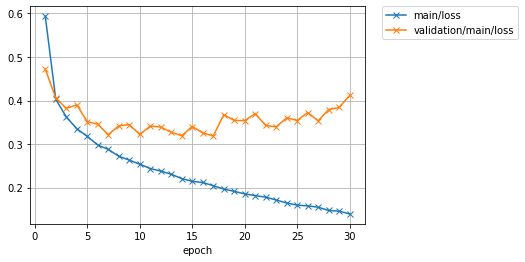

In [16]:
Image(filename='result/loss.png')

In [17]:
test_evalutor = E.Evaluator(test_iter, model_loss, device=gpu_id)
results = test_evalutor()

print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.88587815


In [18]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

%ls -la my_mnist.model

-rw-r--r-- 1 root root 373071  7月 15 14:43 my_mnist.model


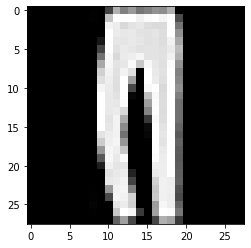

Ground truth: Trouser


In [19]:
infer_model = MLP()

serializers.load_npz('my_mnist.model', infer_model)

if gpu_id >= 0:
    infer_model.to_gpu(gpu_id)
    
x, t = test[2]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('Ground truth:', labels[t])

In [20]:
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

if gpu_id >= 0:
    x = to_gpu(x, 0)
    
with ch.using_config('train', False):
    y = infer_model(x)
    
y = y.data

y = to_cpu(y)

print('Label values: ', np.around(y, decimals=1))

pred_label = y.argmax(axis=1)

print('Predicted label: ', labels[pred_label[0]])

(784,) -> (1, 784)
Label values:  [[ -3.5  36.5 -28.6  -4.1 -25.8 -26.3  -5.  -43.9 -29.4 -34.6]]
Predicted label:  Trouser
